# Long Short Term Memory Networks

This Jupyter Notebook contains the examples mentioned in the article [To Know Is Also to Remember](https://medium.com/towards-data-science/to-know-is-also-to-remember-e786cc6242ae):
- Implementation of a single-unit LSTM network (Vanilla LSTM) from scracth and application to a continuous function
- Using the Vanilla LSTM in a word predictor app and compare it with a [Keras](https://keras.io/) LSTM

For these examples we will need the following libraries:


In [7]:
#To handle equations and plotting
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import string

#To scale the data and calculate the MSE
from sklearn.metrics import mean_squared_error 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#To build a LSTM using Keras
import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential, load_model, Model
from keras import Input 
from keras.layers import Dense, SimpleRNN, LSTM, Embedding

## Example 1. Building a single-unit LSTM network from scratch:

### Data preparation:
As it was explained in these articles about [LSTM]() networks and [RNNs](https://medium.com/towards-artificial-intelligence/recurrent-neural-networks-a-very-special-kind-of-mnemonist-cd0b0a41fe75), how data enters into a RNN is different from the usual set of input/target data that is used in a conventional Artificial Neural Network (ANN). In the case of RNN, the input data consists of multiple sequences of values whose target is the following value on the list. This is better explained in the following picture:

<img src=inc\Seq_length.png width=450/>

The function `PrepareData` takes a .csv file with two columns (independent and dependent variable) and turns it into a list of arrays that are used as the main input in a recurrent network. These arrays are split into a train and test section as is usually done in the training process of neural networks. Note how one of the inputs of this function is the sequence length. Different sequence lengths will generate different sizes of the dataset and will alter the results and performance of the RNN. The following figure is a graphical explanation of what the stage of data preparation does:

<img src=inc\Data_Preparation.png width=450/>

### Initialize parameters:
The function `Get_Params` initializes the weights and biases of the LSTM network.


### Calculate Loss
This is a function that will be called multiple times during the training process. It takes the input, feeds it into the LSTM network and then compares the output with the targets. In this example, the loss function used is the following:
$$
\sum_{i=1}^{N} \frac{(\hat{y}-y)^2}{2}
$$
$\hat{y}$ represents the output, $y$ represents the target and $N$ is the number of values that are used in the calculation. This loss function is useful for these types of exercises where we are tying to model a continuos function. If you want to apply an LSTM network to a categorical problem, then this loss function is not a good choice.

### Forward Propagation
The `forwardprop` function takes into account the weights and biases, the values of the hidden state ($h_{t-1}$) and cell state ($C_{t-1}$) and the current input ($x_t$) and calculates the new hidden state ($h_{t}$) and cell state ($C_{t}$). This calculation considers the activations functions across the three gates (or stages) in a LSTM network cell:

<img src=inc\Forward_Prop_LSTM.png width=750/>

In the previous picture:

- The forget gate includes a weight for the input ($w_{xf}$), a weight for the hidden state ($w_{hf}$) and a bias ($b_{xf}$). The activation function is sigmoid ($\sigma$) 
- The output gate includes a weight for the input ($w_{xo}$), a weight for the hidden state ($w_{ho}$) and a bias ($b_{xo}$). The activation function is sigmoid ($\sigma$) 
- The input gate includes two weights for the input ($w_{x2}$ and $w_{x3}$), two weights for the hidden state ($w_{h2}$ and $w_{h3}$) and two biases ($b_{x2}$ and $b_{x3}$). The activation functions are sigmoid ($\sigma$) and tanh ($th$)


### Backward Propagation
In the backward propagation process, the differences between the outputs and the targets (measured by the loss function) are distributed backwards through the network. A gradient is calculated for each of the weights and biases and then these parameters are modified accordingly. The following picture shows all the equations that are used in the backpropagation process. It is important to note that the difference between this process and the other back propagation that is done in conventional ANN, is that in the case of RNN or LSTM networks the gradients are summed at each iteration to account for the fact that the inputs are going into the hidden layer sequentially.

<img src=inc\Backprop_eq.png width=1000/>

### Training
The `train` function will do a forward propagation, calculate the loss, then backward propagate this loss to calculate the gradients and update the parameters according to the gradients. This process will be repeated a finite number of times that is specified by the variable `epoch` inside the function. The final output of the training process is to get a set of parameters that generate an output that is close to the target. The `train` function implemented here keeps a report of the loss value at each iteration and it also prints the loss and the MSE at each epoch. 

All these functions are defined as follows:

In [8]:

### DATA PREPARATION ###
# Function: PrepareData
# Input: 
#       - File: a .csv file that contains two columns. The first column is the independent variable and 
#               the second is the dependant variable. All the training is done with the second column but 
#               the first one is used to plot with the raw data
#       - seq_len: sequence length
#       - test_frac: fraction of the data that will be used to test
# Output:
#       - X: numpy array with the input data to train
#       - Y: numpy array with the target data to train
#       - X_test: numpy array with the input data to test
#       - Y_test: numpy array with the target data to test
#       - X_raw: numpy array with the independent variable as it appears in the .csv file
#       - Y_raw: numpy array with the dependent variable as it appears in the .csv file
#       - Scaler: scaler properties to revert the changes later
def PrepareData(File,seq_len,test_frac):
    
    #Extract data from the csv file
    Raw_Data=pd.read_csv(File)
    Raw_Data=Raw_Data.to_numpy()
    X_raw=Raw_Data[:,0]
    Y_raw=Raw_Data[:,1]
    
    #Scale the data.
    Scaler=MinMaxScaler((-1,1)).fit(Y_raw.reshape(-1, 1))
    #Scaler=StandardScaler().fit(Y_raw.reshape(-1, 1))
    data=Scaler.transform(Y_raw.reshape(-1, 1))
    data=data.reshape(-1)

    #Build variables
    X = []
    Y = []
    X_test = []
    Y_test = []
    num_records = len(data) - seq_len
    num_test=int(num_records*test_frac)
    num_train=num_records-num_test
    
    for i in range(num_train):
        X.append(data[i:i+seq_len])
        Y.append(data[i+seq_len])
    X = np.expand_dims(np.array(X), axis=2) 
    Y = np.expand_dims(np.array(Y), axis=1) 

    for i in range(num_train, num_train+num_test):
        X_test.append(data[i:i+seq_len])
        Y_test.append(data[i+seq_len])
    X_test = np.expand_dims(np.array(X_test), axis=2) 
    Y_test = np.expand_dims(np.array(Y_test), axis=1)
    
    return X,Y,X_test,Y_test,X_raw,Y_raw,Scaler

########################


### INITIALIZE PARAMETERS ###
# Function: Get_Params
# Input: 
#       - random: specify if you want to generate the parameters randomly or using a seed. A value of 0 means random
# Output:
#       - Parameters: dictionary with all the parameters
def Get_Params(random=0):

    if random!=0:
        np.random.seed(random) 
    
    Parameters={}
    
    #Forget Gate
    Parameters["Wxf"]=np.random.uniform(-1,1,(1,1))
    Parameters["Whf"]=np.random.uniform(-1,1,(1,1))
    Parameters["bxf"]=np.zeros((1,1))
    
    #Input Gate
    Parameters["Wx2"]=np.random.uniform(-1,1,(1,1))
    Parameters["Wh2"]=np.random.uniform(-1,1,(1,1))
    Parameters["bx2"]=np.zeros((1,1))
    
    Parameters["Wx3"]=np.random.uniform(-1,1,(1,1))
    Parameters["Wh3"]=np.random.uniform(-1,1,(1,1))
    Parameters["bx3"]=np.zeros((1,1))
    
    #Output Gate
    Parameters["Wxo"]=np.random.uniform(-1,1,(1,1))
    Parameters["Who"]=np.random.uniform(-1,1,(1,1))
    Parameters["bxo"]=np.zeros((1,1))
    
    #States
    Parameters["ht1"]=np.zeros((1,seq_len+1))
    Parameters["Ct1"]=np.zeros((1,seq_len+1))
    
    return Parameters

############################

### SIGMOID FUNCTION ###
# Function: sigmoid
# Input: 
#       - X
# Output:
#       - y: the sigmoid of x
def sigmoid(x):
    y=1/(1 + np.exp(-x))
    return y

############################

### DERIVATIVE OF SIGMOID FUNCTION ###
# Function: d_sigmoid
# Input: 
#       - X
# Output:
#       - y: the derivative of the sigmoid of x
def d_sigmoid(x):
    y=sigmoid(x)*(1-sigmoid(x))
    return y

############################

############################

### DERIVATIVE OF TANH FUNCTION ###
# Function: d_tanh
# Input: 
#       - X
# Output:
#       - y: the derivative of the tanh of x
def d_tanh(x):
    y=1-np.tanh(x)**2
    return y

############################


### CALCULATE LOSS ###
# Function: calc_loss
# Input: 
#       - X: numpy array with the input data
#       - Y: numpy array with the target data
#       - Parameters: dictionary with the parameters
#       - seq_len: sequence length
# Output:
#       - loss: a value that measures the loss using the square error
def calc_loss(X,Y,Parameters,seq_len):
    # Retrieve parameters
    Whf=Parameters["Whf"]
    bxf=Parameters["bxf"]
    Wxf=Parameters["Wxf"]
    
    Wh2=Parameters["Wh2"]
    bx2=Parameters["bx2"]
    Wx2=Parameters["Wx2"]
    Wh3=Parameters["Wh3"]
    bx3=Parameters["bx3"]
    Wx3=Parameters["Wx3"]
    
    Who=Parameters["Who"]
    bxo=Parameters["bxo"]
    Wxo=Parameters["Wxo"]
    
    ht1=Parameters["ht1"]
    Ct1=Parameters["Ct1"]
     
    loss=0
    for i in range(Y.shape[0]):
        xi,yi=X[i],Y[i]
        
        for t in range(seq_len):
            
            #Forget Gate
            zf=Wxf*xi[t]+bxf+Whf*ht1[:,t]
            af=sigmoid(zf)
            
            #Input Gate
            z2=Wx2*xi[t]+bx2+Wh2*ht1[:,t]
            a2=sigmoid(z2)
            z3=Wx3*xi[t]+bx3+Wh3*ht1[:,t]
            a3=np.tanh(z3)
            
            #Output Gate
            zo=Wxo*xi[t]+bxo+Who*ht1[:,t]
            a0=sigmoid(zo)
            
            #Ct=Ct1*af+a2*a3
            #ht=a0*np.tanh(Ct)
            LTM=Ct1[:,t]*af+a2*a3
            STM=a0*np.tanh(LTM)
            Ct1[:,t+1]=LTM
            ht1[:,t+1]=STM          
            
        loss_t=(yi-STM)**2/2 #Dividing the square error by 2 simplifies the backprop later
        loss += loss_t
    return loss   
    
    
######################


### FORWARD PROPAGATION ###
# Function: forwardprop
# Input: 
#       - xi: a single input value
#       - Parameters: dictionary with the parameters
# Output:
#       - A2: the output value at the end of the network
#       - cache: activation values that will be used later during the backprop
def forwardprop(xi,Parameters):
    # Retrieve parameters
    Whf=Parameters["Whf"]
    bxf=Parameters["bxf"]
    Wxf=Parameters["Wxf"]
    
    Wh2=Parameters["Wh2"]
    bx2=Parameters["bx2"]
    Wx2=Parameters["Wx2"]
    Wh3=Parameters["Wh3"]
    bx3=Parameters["bx3"]
    Wx3=Parameters["Wx3"]
    
    Who=Parameters["Who"]
    bxo=Parameters["bxo"]
    Wxo=Parameters["Wxo"]
    
    ht1=Parameters["ht1"]
    Ct1=Parameters["Ct1"]
    cache={}
    
    Zf=np.zeros((1,seq_len))
    Af=np.zeros((1,seq_len))
    Z2=np.zeros((1,seq_len))
    A2=np.zeros((1,seq_len))
    Z3=np.zeros((1,seq_len))
    A3=np.zeros((1,seq_len))
    Zo=np.zeros((1,seq_len))
    Ao=np.zeros((1,seq_len))
    
    Ct=np.zeros((1,seq_len))
    ht=np.zeros((1,seq_len))

    
    for t in range(seq_len):      
        Zf[:,t]=Wxf*xi[t]+bxf+np.dot(Whf,ht1[:,t])
        Af[:,t]=sigmoid(Zf[:,t])
        
        Z2[:,t]=Wx2*xi[t]+bx2+np.dot(Wh2,ht1[:,t])
        A2[:,t]=sigmoid(Z2[:,t])
        Z3[:,t]=Wx3*xi[t]+bx3+np.dot(Wh3,ht1[:,t])
        A3[:,t]=np.tanh(Z3[:,t])
        
        Zo[:,t]=Wxo*xi[t]+bxo+np.dot(Who,ht1[:,t])
        Ao[:,t]=sigmoid(Zo[:,t])
        
        Ct[:,t]=Ct1[:,t]*Af[:,t]+A2[:,t]*A3[:,t]
        ht[:,t]=Ao[:,t]*np.tanh(Ct[:,t])
        
        ht1[:,t+1]=ht[:,t]
        Ct1[:,t+1]=Ct[:,t]
        
           
    cache["Zf"]=Zf
    cache["Af"]=Af
    cache["Z2"]=Z2
    cache["A2"]=A2
    cache["Z3"]=Z3
    cache["A3"]=A3
    cache["Zo"]=Zo
    cache["Ao"]=Ao
    cache["Ct"]=Ct
    cache["ht"]=ht
    #cache["ht1"]=ht1
    #cache["Ct1"]=Ct1
    
    return ht,cache

###########################


### BACKWARD PROPAGATION ###
# Function: backprop
# Input: 
#       - xi: a single input value
#       - yi: a single target value
#       - A2: a single output value
#       - Parameters: dictionary with the parameters
#       - cache: dictionary with the activations
#       - max_clip, min_clip: max and min limits for clipping the gradients
# Output:
#       - grads: dictionary with the gradients
def backprop(xi,yi,ht,Parameters,cache,max_clip=2,min_clip=-2):
    #Retrieve parameters
    Zf=cache["Zf"]
    Af=cache["Af"]
    Z2=cache["Z2"]
    A2=cache["A2"]
    Z3=cache["Z3"]
    A3=cache["A3"]
    Zo=cache["Zo"]
    Ao=cache["Ao"]
    Ct=cache["Ct"]
    ht=cache["ht"]
    
    Whf=Parameters["Whf"]
    bxf=Parameters["bxf"]
    Wxf=Parameters["Wxf"]
    Wh2=Parameters["Wh2"]
    bx2=Parameters["bx2"]
    Wx2=Parameters["Wx2"]
    Wh3=Parameters["Wh3"]
    bx3=Parameters["bx3"]
    Wx3=Parameters["Wx3"]
    Who=Parameters["Who"]
    bxo=Parameters["bxo"]
    Wxo=Parameters["Wxo"]
    ht1=Parameters["ht1"]
    Ct1=Parameters["Ct1"]
    
    #Initialize derivatives
    d_Zf=np.zeros((1,seq_len))
    d_Af=np.zeros((1,seq_len+1))
    d_Z2=np.zeros((1,seq_len))
    d_A2=np.zeros((1,seq_len+1))
    d_Z3=np.zeros((1,seq_len))
    d_A3=np.zeros((1,seq_len+1))
    d_Zo=np.zeros((1,seq_len))
    d_Ao=np.zeros((1,seq_len+1))
    d_Ct=np.zeros((1,seq_len))
    d_ht=np.zeros((1,seq_len))
    
    d_Whf=np.zeros((1,seq_len+1))
    d_bxf=np.zeros((1,seq_len+1))
    d_Wxf=np.zeros((1,seq_len+1))
    d_Wh2=np.zeros((1,seq_len+1))
    d_bx2=np.zeros((1,seq_len+1))
    d_Wx2=np.zeros((1,seq_len+1))
    d_Wh3=np.zeros((1,seq_len+1))
    d_bx3=np.zeros((1,seq_len+1))
    d_Wx3=np.zeros((1,seq_len+1))
    d_Who=np.zeros((1,seq_len+1))
    d_bxo=np.zeros((1,seq_len+1))
    d_Wxo=np.zeros((1,seq_len+1))
    d_ht1=np.zeros((1,seq_len+1))
    d_Ct1=np.zeros((1,seq_len+1))
    
    #Backprop
    for t in reversed(range(seq_len)):
        #ht
        d_ht[:,t]=(yi-ht[:,t])
        #Ct
        d_Ct[:,t]=d_ht[:,t]*(Ao[:,t]*(1-np.tanh(Ct[:,t])**2))
        #Output gate
        d_Ao[:,t]=d_ht[:,t]*np.tanh(Ct[:,t])
        #Input gate
        d_A2[:,t]=d_Ct[:,t]*A3[:,t]
        d_A3[:,t]=d_Ct[:,t]*A2[:,t]
        #Forget gate
        d_Af[:,t]=d_Ct[:,t]*Ct1[:,t]
        #Ct-1
        d_Ct1[:, t]=(d_Ct[:, t] * Af[:, t])+d_Ct1[:, t+1]
        #Output gate weights
        d_Wxo[:,t]=d_Ao[:,t]*sigmoid(Zo[:,t])*(1-sigmoid(Zo[:,t]))*xi[t]+d_Wxo[:,t+1]
        d_bxo[:,t]=d_Ao[:,t]*sigmoid(Zo[:,t])*(1-sigmoid(Zo[:,t]))+d_bxo[:,t+1]
        d_Who[:,t]=d_Ao[:,t]*sigmoid(Zo[:,t])*(1-sigmoid(Zo[:,t]))*ht1[:,t]+d_Who[:,t+1]
        #Forget gate weights
        d_Wxf[:,t]=d_Af[:,t]*sigmoid(Zf[:,t])*(1-sigmoid(Zf[:,t]))*xi[t]+d_Wxf[:,t+1]
        d_bxf[:,t]=d_Af[:,t]*sigmoid(Zf[:,t])*(1-sigmoid(Zf[:,t]))+d_bxf[:,t+1]
        d_Whf[:,t]=d_Af[:,t]*sigmoid(Zf[:,t])*(1-sigmoid(Zf[:,t]))*ht1[:,t]+d_Whf[:,t+1]
        #Input gate weights
        d_Wx2[:,t]=d_A2[:,t]*sigmoid(Z2[:,t])*(1-sigmoid(Z2[:,t]))*xi[t]+d_Wx2[:,t+1]
        d_bx2[:,t]=d_A2[:,t]*sigmoid(Z2[:,t])*(1-sigmoid(Z2[:,t]))+d_bx2[:,t+1]
        d_Wh2[:,t]=d_A2[:,t]*sigmoid(Z2[:,t])*(1-sigmoid(Z2[:,t]))*ht1[:,t]+d_Wh2[:,t+1]
        d_Wx3[:,t]=d_A3[:,t]*(1-np.tanh(Z3[:,t])**2)*xi[t]+d_Wx3[:,t+1]
        d_bx3[:,t]=d_A3[:,t]*(1-np.tanh(Z3[:,t])**2)+d_bx3[:,t+1]
        d_Wh3[:,t]=d_A3[:,t]*(1-np.tanh(Z3[:,t])**2)*ht1[:,t]+d_Wh3[:,t+1]
        #ht-1
        d_ht1[:,t]=d_ht[:,t]*(d_sigmoid(Zo[:,t])*Who[0]*np.tanh(Ct[:,t])+
                              sigmoid(Zo[:,t])*d_tanh(Ct[:,t])*(Ct1[:,t]*d_sigmoid(Zf[:,t])*Whf[0]+
                                                              d_sigmoid(Z2[:,t])*Wh2[0]*np.tanh(Z3[:,t])+
                                                              sigmoid(Z2[:,t])*d_tanh(Z3[:,t])*Wh3[0]))+d_ht1[:,t+1]#Accumulating      
      
                
    #Dealing with exploding and vanishing gradients
    d_Ao=np.clip(d_Ao, min_clip, max_clip)
    d_Ct=np.clip(d_Ct, min_clip, max_clip)
    d_A2=np.clip(d_A2, min_clip, max_clip)
    d_A3=np.clip(d_A3, min_clip, max_clip)
    d_Af=np.clip(d_Af, min_clip, max_clip)
    d_Ct1=np.clip(d_Ct1, min_clip, max_clip)
    d_Wxo=np.clip(d_Wxo, min_clip, max_clip)
    d_bxo=np.clip(d_bxo, min_clip, max_clip)
    d_Who=np.clip(d_Who, min_clip, max_clip)
    d_Wxf=np.clip(d_Wxf, min_clip, max_clip)
    d_bxf=np.clip(d_bxf, min_clip, max_clip)
    d_Whf=np.clip(d_Whf, min_clip, max_clip)
    d_Wx2=np.clip(d_Wx2, min_clip, max_clip)
    d_bx2=np.clip(d_bx2, min_clip, max_clip)
    d_Wh2=np.clip(d_Wh2, min_clip, max_clip)
    d_Wx3=np.clip(d_Wx3, min_clip, max_clip)
    d_bx3=np.clip(d_bx3, min_clip, max_clip)
    d_Wh3=np.clip(d_Wh3, min_clip, max_clip)       
    d_ht1=np.clip(d_ht1, min_clip, max_clip)
    
    d_Whf=d_Whf[:,:-1]
    d_bxf=d_bxf[:,:-1]
    d_Wxf=d_Wxf[:,:-1]
    d_Wh2=d_Wh2[:,:-1]
    d_bx2=d_bx2[:,:-1]
    d_Wx2=d_Wx2[:,:-1]
    d_Wh3=d_Wh3[:,:-1]
    d_bx3=d_bx3[:,:-1]
    d_Wx3=d_Wx3[:,:-1]
    d_Who=d_Who[:,:-1]
    d_bxo=d_bxo[:,:-1]
    d_Wxo=d_Wxo[:,:-1]
    d_Ct1=d_Ct1[:,:-1]
    d_ht1=d_ht1[:,:-1]
    d_Af=d_Af[:,:-1]
    d_Ao=d_Ao[:,:-1]
    d_A2=d_A2[:,:-1]
    d_A3=d_A3[:,:-1]
    
    #Saving the gradients in a dictionary
    grads={}
    grads["d_Zf"]=d_Zf
    grads["d_Af"]=d_Af
    grads["d_Z2"]=d_Z2
    grads["d_A2"]=d_A2
    grads["d_Z3"]=d_Z3
    grads["d_A3"]=d_A3
    grads["d_Zo"]=d_Zo
    grads["d_Ao"]=d_Ao
    grads["d_Ct"]=d_Ct
    grads["d_ht"]=d_ht
    
    grads["d_Whf"]=d_Whf
    grads["d_bxf"]=d_bxf
    grads["d_Wxf"]=d_Wxf
    grads["d_Wh2"]=d_Wh2
    grads["d_bx2"]=d_bx2
    grads["d_Wx2"]=d_Wx2
    grads["d_Wh3"]=d_Wh3
    grads["d_bx3"]=d_bx3
    grads["d_Wx3"]=d_Wx3
    grads["d_Who"]=d_Who
    grads["d_bxo"]=d_bxo
    grads["d_Wxo"]=d_Wxo
    grads["d_ht1"]=d_ht1
    grads["d_Ct1"]=d_Ct1

    
    return grads

############################

### PREDICTION ###
# Function: prediction
# Input: 
#       - X: numpy array with the input data
#       - Parameters: dictionary with the parameters
#       - seq_len: sequence length
# Ouput:
#       - y_hat: numpy array with the output data
def prediction(X,Parameters,seq_len):
    y_hat=np.zeros((X.shape[0]))
    for n in range(X.shape[0]):
        xi=X[n]
        A2,cache=forwardprop(xi,Parameters)
        y_hat[n]=A2[0,seq_len-1]
    return y_hat

##################

### TRAINING ###
# Function: train
# Input: 
#       - X: numpy array with the input data
#       - Y: numpy array with the target data
#       - Parameters: dictionary with the parameters
#       - epochs: number of epochs
#       - learning_rate
#       - MSE: boolean that defines if the MSE is printed at each epoch
#       - verbose: boolean that defines if the loss is printed at each iteration

# Output:
#       - Parameters: dictionary with the modified parameters after the training
#       - test_loss: final number of the loss for the test dataset
#       - A: table with the epoch and the test loss
def train(X,Y,Parameters,epochs=20,learning_rate=0.0001,MSE=True,verbose=False):
    A=np.zeros((epochs,2))
    for k in range(epochs):
        loss=calc_loss(X,Y,Parameters,seq_len)
        test_loss=calc_loss(X_test,Y_test,Parameters,seq_len)
        y_test=prediction(X_test,Parameters,seq_len)
        MSE_test=mean_squared_error(Y_test,y_test)
        
        if verbose==True:
            print(f'Epoch: {k+1}, Loss: {loss}, Validation Loss: {test_loss}, MSE test: {MSE_test}')
        
        #Training
        for i in range(Y.shape[0]):
            
            xi,yi=X[i],Y[i]
            #Forward Propagation
            A2,cache=forwardprop(xi,Parameters)
            #Backward Propagation
            grads=backprop(xi,yi,A2,Parameters,cache)
            #Update Parameters
            
            Parameters["Whf"] += learning_rate*grads["d_Whf"][:,0]
            Parameters["bxf"] += learning_rate*grads["d_bxf"][:,0]
            Parameters["Wxf"] += learning_rate*grads["d_Wxf"][:,0]
            Parameters["Wh2"] += learning_rate*grads["d_Wh2"][:,0]
            Parameters["bx2"] += learning_rate*grads["d_bx2"][:,0]
            Parameters["Wx2"] += learning_rate*grads["d_Wx2"][:,0]
            Parameters["Wh3"] += learning_rate*grads["d_Wh3"][:,0]
            Parameters["bx3"] += learning_rate*grads["d_bx3"][:,0]
            Parameters["Wx3"] += learning_rate*grads["d_Wx3"][:,0]
            Parameters["Who"] += learning_rate*grads["d_Who"][:,0]
            Parameters["bxo"] += learning_rate*grads["d_bxo"][:,0]
            Parameters["Wxo"] += learning_rate*grads["d_Wxo"][:,0]
            
            Parameters["ht1"] += learning_rate*grads["d_ht1"][:,0]
            Parameters["Ct1"] += learning_rate*grads["d_Ct1"][:,0]
        A[k,0]=k
        A[k,1]=test_loss
        
        if k>1 and A[k,1]>A[k-1,1]:
            print("Validation loss increased") #If the loss in the new iteration increases, the training process stops
            break
        
    loss=calc_loss(X,Y,Parameters,seq_len)
    test_loss=calc_loss(X_test,Y_test,Parameters,seq_len)
    
    if MSE==True:
        print(f'The training loss is: {loss} and the validation loss is: {test_loss}')
    
    y_train=prediction(X,Parameters,seq_len)
    y_test=prediction(X_test,Parameters,seq_len)
    MSE_train=mean_squared_error(Y,y_train)
    MSE_test=mean_squared_error(Y_test,y_test)
    if MSE==True:
        print(f'The training MSE is: {MSE_train} and the test MSE is: {MSE_test}' )
    
    
    return Parameters, test_loss, A, grads

################


#### Case A. Sin function
Let's try to use the previous code to model a simple $sin(x)$ function. The input values are stores in `sin.csv`. The LSTM network will read this file, generate the training and testing dataset and then adjust the parameters accordingly. After the training process finishes, the new parameters are saved in the variable `New_Param`. This variable is then used with the function `prediction` to generate new values for the $sin(x)$ function using the LSTM network.

Epoch: 1, Loss: [[54.3445603]], Validation Loss: [[21.10193876]], MSE test: 0.8613036229311036
Epoch: 2, Loss: [[52.98275518]], Validation Loss: [[20.45999935]], MSE test: 0.8351020144702566
Epoch: 3, Loss: [[51.6122777]], Validation Loss: [[19.81006704]], MSE test: 0.8085741647485155
Epoch: 4, Loss: [[50.24008755]], Validation Loss: [[19.15559755]], MSE test: 0.7818611244746083
Epoch: 5, Loss: [[48.87699092]], Validation Loss: [[18.50225784]], MSE test: 0.7551941973860375
Epoch: 6, Loss: [[47.53638875]], Validation Loss: [[17.85721298]], MSE test: 0.7288658359540621
Epoch: 7, Loss: [[46.23119174]], Validation Loss: [[17.22712677]], MSE test: 0.7031480316112653
Epoch: 8, Loss: [[44.97088591]], Validation Loss: [[16.61693522]], MSE test: 0.6782422539478455
Epoch: 9, Loss: [[43.76160201]], Validation Loss: [[16.03005195]], MSE test: 0.6542878347464779
Epoch: 10, Loss: [[42.60759066]], Validation Loss: [[15.46896907]], MSE test: 0.6313864926030446
Epoch: 11, Loss: [[41.51222912]], Validat

Epoch: 86, Loss: [[21.04069611]], Validation Loss: [[6.0175311]], MSE test: 0.24561351424696515
Epoch: 87, Loss: [[20.92400424]], Validation Loss: [[5.97927407]], MSE test: 0.24405200265760787
Epoch: 88, Loss: [[20.80747562]], Validation Loss: [[5.9412061]], MSE test: 0.2424982083524617
Epoch: 89, Loss: [[20.69107356]], Validation Loss: [[5.90331364]], MSE test: 0.24095157718029486
Epoch: 90, Loss: [[20.57476228]], Validation Loss: [[5.86558356]], MSE test: 0.23941157381404884
Epoch: 91, Loss: [[20.45850682]], Validation Loss: [[5.82800319]], MSE test: 0.23787768113955593
Epoch: 92, Loss: [[20.34227308]], Validation Loss: [[5.79056029]], MSE test: 0.23634939973882274
Epoch: 93, Loss: [[20.22602784]], Validation Loss: [[5.75324306]], MSE test: 0.23482624746053668
Epoch: 94, Loss: [[20.10973871]], Validation Loss: [[5.7160401]], MSE test: 0.23330775907092033
Epoch: 95, Loss: [[19.99337421]], Validation Loss: [[5.67894041]], MSE test: 0.2317934859784916
Epoch: 96, Loss: [[19.87690373]], V

Epoch: 171, Loss: [[10.48752627]], Validation Loss: [[2.95835778]], MSE test: 0.12074929716552259
Epoch: 172, Loss: [[10.3742225]], Validation Loss: [[2.9284577]], MSE test: 0.11952888573961414
Epoch: 173, Loss: [[10.2620984]], Validation Loss: [[2.8989133]], MSE test: 0.11832299179053195
Epoch: 174, Loss: [[10.15117767]], Validation Loss: [[2.86972948]], MSE test: 0.11713181548336823
Epoch: 175, Loss: [[10.04148248]], Validation Loss: [[2.84091075]], MSE test: 0.11595554076346741
Epoch: 176, Loss: [[9.93303344]], Validation Loss: [[2.81246121]], MSE test: 0.11479433529140687
Epoch: 177, Loss: [[9.82584961]], Validation Loss: [[2.78438459]], MSE test: 0.11364835043114545
Epoch: 178, Loss: [[9.7199485]], Validation Loss: [[2.75668417]], MSE test: 0.11251772128938144
Epoch: 179, Loss: [[9.61534606]], Validation Loss: [[2.72936289]], MSE test: 0.11140256680396955
Epoch: 180, Loss: [[9.51205667]], Validation Loss: [[2.70242325]], MSE test: 0.11030298987907415
Epoch: 181, Loss: [[9.4100932]

Epoch: 256, Loss: [[5.10406198]], Validation Loss: [[1.60179462]], MSE test: 0.06537937205292546
Epoch: 257, Loss: [[5.07781946]], Validation Loss: [[1.59573251]], MSE test: 0.0651319389960676
Epoch: 258, Loss: [[5.05204277]], Validation Loss: [[1.58978908]], MSE test: 0.06488935030324419
Epoch: 259, Loss: [[5.02672167]], Validation Loss: [[1.58396159]], MSE test: 0.0646514936182363
Epoch: 260, Loss: [[5.00184614]], Validation Loss: [[1.57824735]], MSE test: 0.06441825909197128
Epoch: 261, Loss: [[4.97740637]], Validation Loss: [[1.57264371]], MSE test: 0.06418953934588817
Epoch: 262, Loss: [[4.95339278]], Validation Loss: [[1.56714812]], MSE test: 0.06396522943433303
Epoch: 263, Loss: [[4.92979598]], Validation Loss: [[1.56175806]], MSE test: 0.06374522680612003
Epoch: 264, Loss: [[4.90660681]], Validation Loss: [[1.55647107]], MSE test: 0.06352943126538761
Epoch: 265, Loss: [[4.88381629]], Validation Loss: [[1.55128475]], MSE test: 0.06331774493186865
Epoch: 266, Loss: [[4.86141565]]

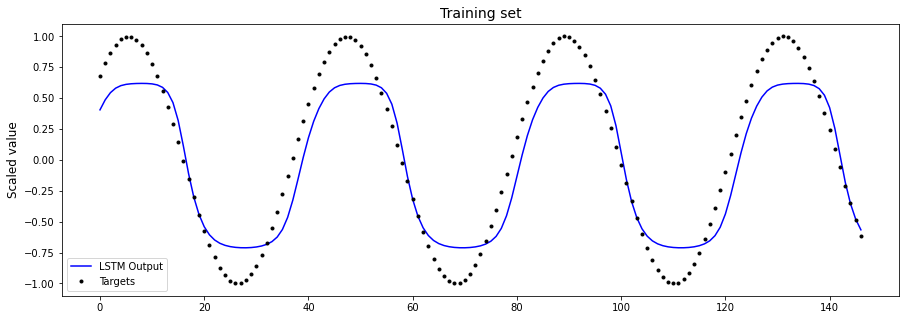

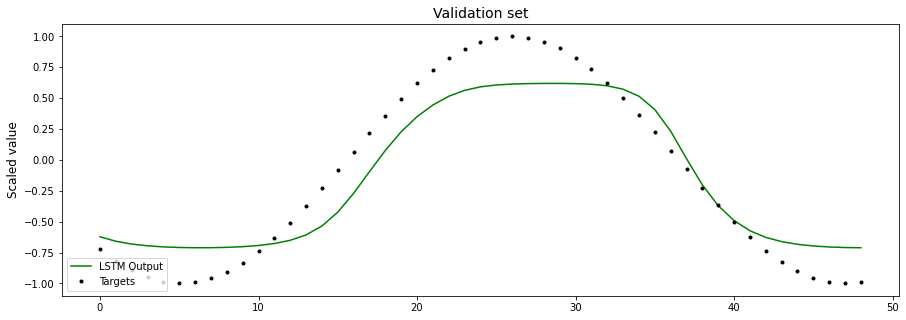

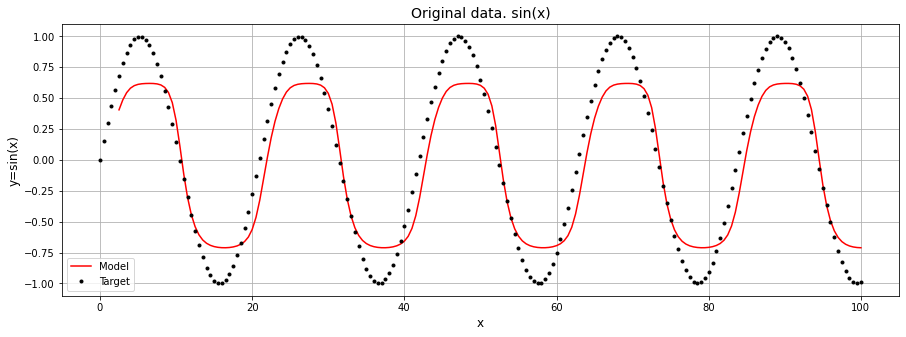

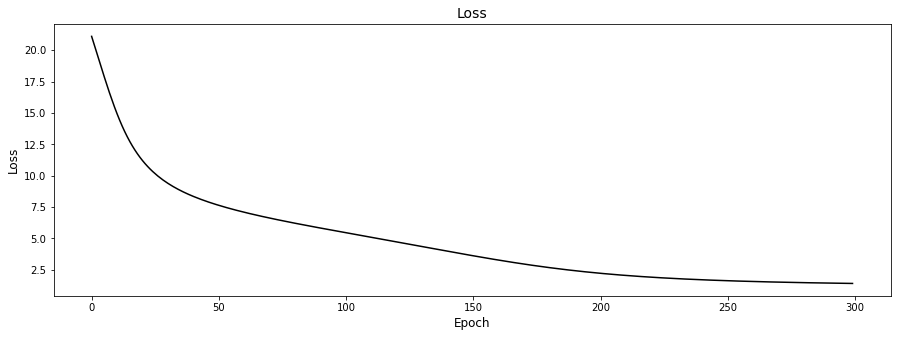

Test set MSE:  0.05777198156341617


In [7]:
#Example with the function sin(x)

#Initial values
seq_len=5

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Sin.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(1) #Define a seed for reproducibility. 0 means random

#Train the RNN
print("Training process starts: ")
New_Param,test_loss,A, grads=train(X,Y,Parameters,epochs=300,learning_rate=0.0005,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='LSTM Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower left') 
plt.show()

#Plot the test set using the scaled values 
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'g', label='LSTM Output')
plt.plot(Y_test, '.k',label='Targets')
plt.title("Validation set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='lower left')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data. sin(x)", fontsize=14)
plt.ylabel('y=sin(x)', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()

#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

We can now build a LSTM network using the **Keras library**. The models built with Keras are not as simple as the model we presented before so we can expect these models to run faster and deliver better results. This [page](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) contains an useful guide of how to configure a RNN using Keras.


Epoch 1/100
144/144 [==============================] - 2s 3ms/step - loss: 0.8910 - mean_squared_error: 0.8910
Epoch 2/100
144/144 [==============================] - 0s 3ms/step - loss: 0.7943 - mean_squared_error: 0.7943
Epoch 3/100
144/144 [==============================] - 0s 3ms/step - loss: 0.7110 - mean_squared_error: 0.7110
Epoch 4/100
144/144 [==============================] - 0s 3ms/step - loss: 0.6450 - mean_squared_error: 0.6450
Epoch 5/100
144/144 [==============================] - 0s 3ms/step - loss: 0.5917 - mean_squared_error: 0.5917
Epoch 6/100
144/144 [==============================] - 0s 3ms/step - loss: 0.5523 - mean_squared_error: 0.5523
Epoch 7/100
144/144 [==============================] - 0s 3ms/step - loss: 0.5213 - mean_squared_error: 0.5213
Epoch 8/100
144/144 [==============================] - 0s 3ms/step - loss: 0.4969 - mean_squared_error: 0.4969
Epoch 9/100
144/144 [==============================] - 0s 3ms/step - loss: 0.4729 - mean_squared_error: 0.4729
E

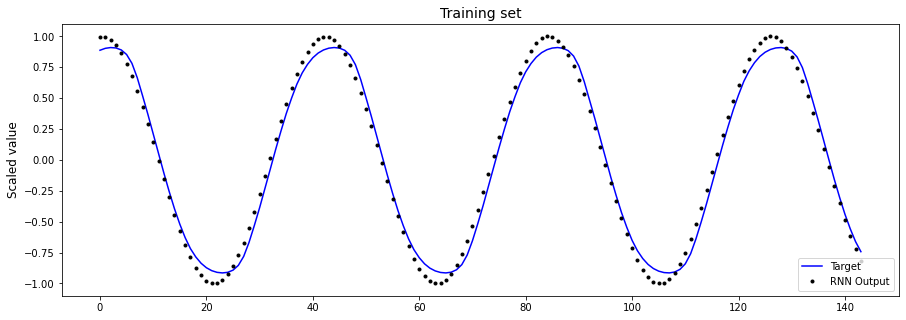

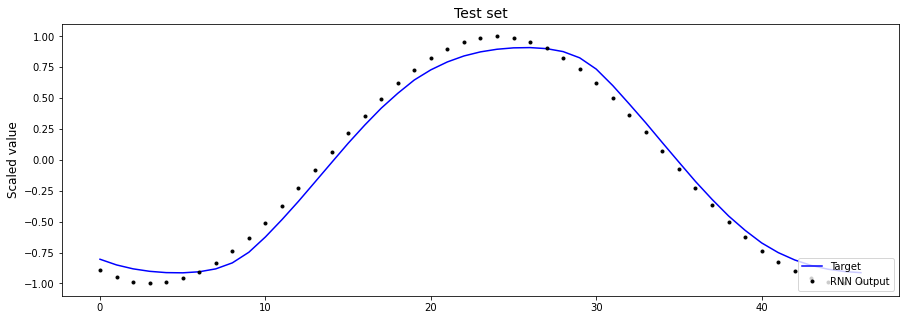

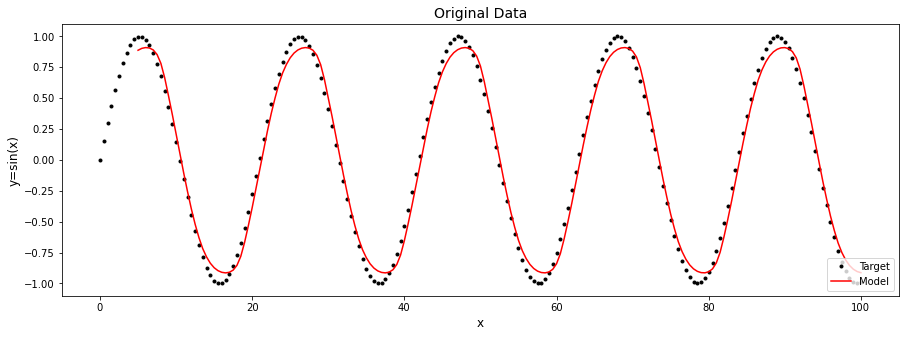

Test set MSE:  0.007293121883596705


In [10]:
seq_len=10

#Define the structure
model = Sequential(name="LSTM-Model") # Model
model.add(Input(shape=(seq_len,1), name='Input Layer')) # Input Layer
model.add(LSTM(units=1, activation='tanh', name='LSTM')) # Hidden Recurrent Layer
#model.add(Dense(units=1, activation='linear', name='Output-Layer')) # Output Layer

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('sin.csv',seq_len,0.25)

#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['MeanSquaredError'])

#Train the RNN
model.fit(X, Y, batch_size=1, epochs=100)

#Predictions
# Predict the result on training data
y_train = model.predict(X)
# Predict the result on test data
y_test = model.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='Target')
plt.plot(Y, '.k', label='RNN Output')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Training set", fontsize=14)
plt.legend(loc='lower right') 
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'b', label='Target')
plt.plot(Y_test, '.k', label='RNN Output')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Test set", fontsize=14)
plt.legend(loc='lower right') 
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw2=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.plot(X_raw[seq_len:],Y_predicted_raw2,'r', label='Model')
plt.title("Original Data", fontsize=14)
plt.ylabel('y=sin(x)', fontsize=12)
plt.xlabel('x', fontsize=12)
plt.legend(loc='lower right')
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

#### Case B. Oil production
In this second case we will take the monthly oil production from an oil well and try to train a LSTM network to reproduce its behaviour. This example is more complicated than the last one because these data does not follow a pattern like the $sin(x)$ function. Instead, it changes drastically with time. As it was done in the previous case, we will compare the results against a Keras model.

The csv file with the raw values is stored in `Declination3.csv`. It contains a columnn for days and a column for oil rate.

Epoch: 1, Loss: [[78.541932]], Validation Loss: [[70.4434321]], MSE test: 0.8973685617421799
Epoch: 2, Loss: [[69.59440352]], Validation Loss: [[61.19532647]], MSE test: 0.7795582990033099
Epoch: 3, Loss: [[63.07239114]], Validation Loss: [[53.96268202]], MSE test: 0.6874227008398657
Epoch: 4, Loss: [[58.19978957]], Validation Loss: [[48.21556275]], MSE test: 0.6142109904541654
Epoch: 5, Loss: [[54.50748294]], Validation Loss: [[43.64247882]], MSE test: 0.5559551441503733
Epoch: 6, Loss: [[51.66725316]], Validation Loss: [[40.00351495]], MSE test: 0.5095989165820485
Epoch: 7, Loss: [[49.43447599]], Validation Loss: [[37.08739802]], MSE test: 0.47245093016866135
Epoch: 8, Loss: [[47.62974982]], Validation Loss: [[34.71318965]], MSE test: 0.4422062376051994
Epoch: 9, Loss: [[46.13018682]], Validation Loss: [[32.74543033]], MSE test: 0.4171392398224735
Epoch: 10, Loss: [[44.85176101]], Validation Loss: [[31.08448912]], MSE test: 0.3959807531504727
Epoch: 11, Loss: [[43.73697635]], Validat

Epoch: 86, Loss: [[13.0027289]], Validation Loss: [[3.42611984]], MSE test: 0.043644838664045
Epoch: 87, Loss: [[12.88662549]], Validation Loss: [[3.35403951]], MSE test: 0.04272661801673568
Epoch: 88, Loss: [[12.77768661]], Validation Loss: [[3.28676517]], MSE test: 0.041869619990472354
Epoch: 89, Loss: [[12.67555848]], Validation Loss: [[3.22406184]], MSE test: 0.041070851494098934
Epoch: 90, Loss: [[12.57989548]], Validation Loss: [[3.16569346]], MSE test: 0.04032730520212829
Epoch: 91, Loss: [[12.49035595]], Validation Loss: [[3.11143151]], MSE test: 0.03963607022598214
Epoch: 92, Loss: [[12.40660235]], Validation Loss: [[3.06105658]], MSE test: 0.03899435138927665
Epoch: 93, Loss: [[12.32830664]], Validation Loss: [[3.014355]], MSE test: 0.03839942681115754
Epoch: 94, Loss: [[12.25515144]], Validation Loss: [[2.97112013]], MSE test: 0.037848664060091367
Epoch: 95, Loss: [[12.18683109]], Validation Loss: [[2.93115294]], MSE test: 0.0373395279381017
Epoch: 96, Loss: [[12.12305482]],

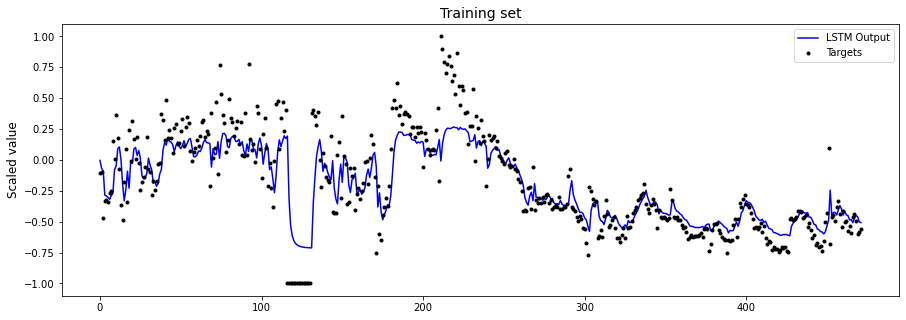

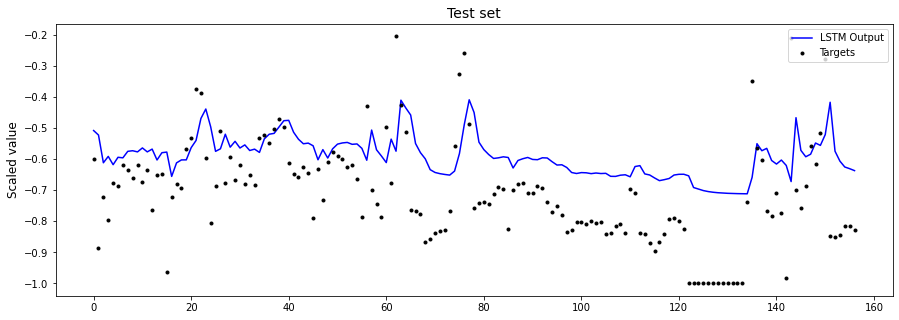

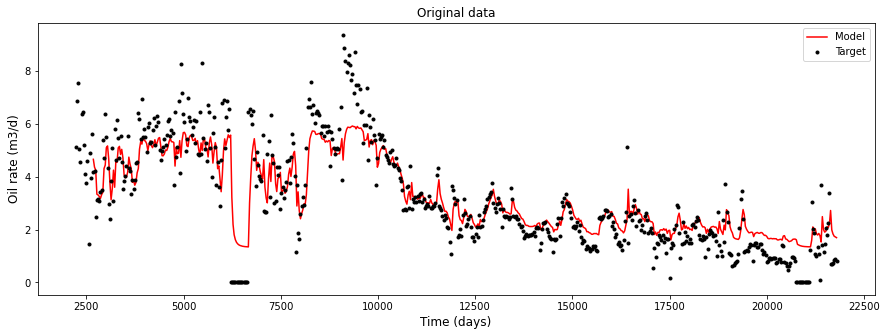

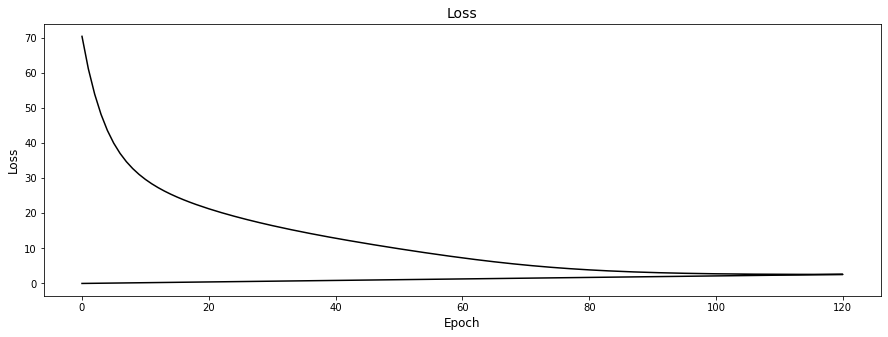

Test set MSE:  0.032827537138049444


In [10]:
#Initial information
seq_len=15

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Declination3.csv',seq_len,0.25)

#Initialize parameters
Parameters=Get_Params(100) #Define a seed for reproducibility

#Train the RNN
New_Param,test_loss,A,grads=train(X,Y,Parameters,epochs=150,learning_rate=0.0004,MSE=True,verbose=True)

#Plot the training set using the scaled values
y_train=prediction(X,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_train, 'b', label='LSTM Output')
plt.plot(Y, '.k', label='Targets')
plt.title("Training set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Plot the test set using the scaled values
y_test=prediction(X_test,New_Param,seq_len)
plt.figure(figsize=(15, 5))
plt.plot(y_test, 'b', label='LSTM Output')
plt.plot(Y_test, '.k', label='Targets')
plt.title("Test set", fontsize=14)
plt.ylabel('Scaled value', fontsize=12)
plt.legend(loc='upper right')
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data
plt.figure(figsize=(15, 5))
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='Model')
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.title("Original data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)',fontsize=12)
plt.title("Original data")
plt.legend(loc='upper right')
plt.show()


#Plot of the loss function
plt.figure(figsize=(15, 5)) 
plt.plot(A[:,0],A[:,1],'k')
plt.title("Loss", fontsize=14)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

We can now compare this with a Keras LSTM network. The following example is using a single unit:

Epoch 1/20
472/472 [==============================] - 2s 2ms/step - loss: 0.0927 - mean_squared_error: 0.0927
Epoch 2/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0611 - mean_squared_error: 0.0611
Epoch 3/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0562 - mean_squared_error: 0.0562
Epoch 4/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0539 - mean_squared_error: 0.0539
Epoch 5/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0528 - mean_squared_error: 0.0528
Epoch 6/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0515 - mean_squared_error: 0.0515
Epoch 7/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0503 - mean_squared_error: 0.0503
Epoch 8/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0493 - mean_squared_error: 0.0493
Epoch 9/20
472/472 [==============================] - 1s 2ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 10/2

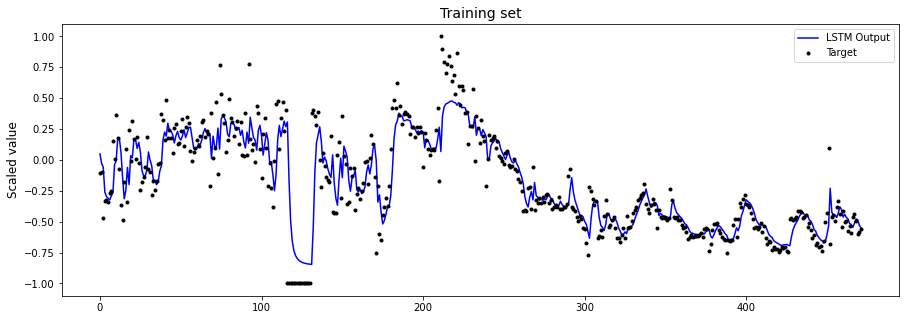

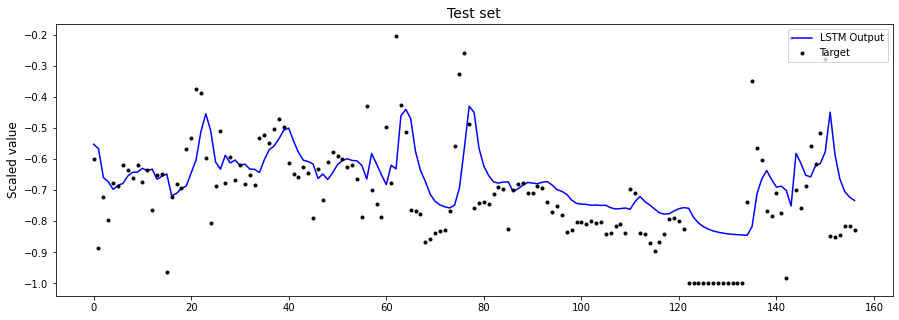

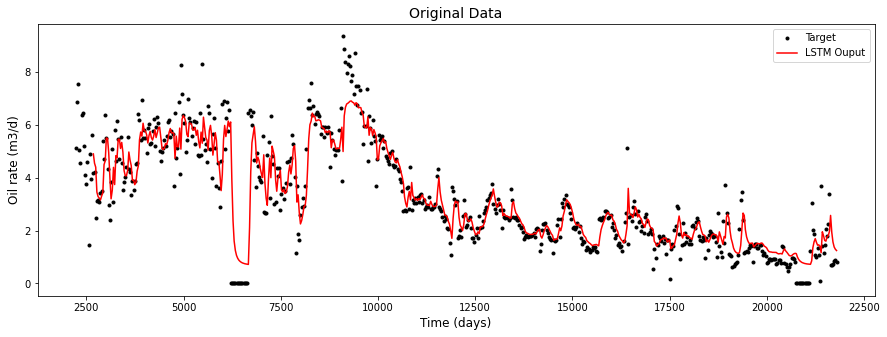

Test set MSE:  0.020914043146597044


In [3]:

seq_len=15

#Define the structure
model = Sequential(name="LSTM-Model") # Model
model.add(Input(shape=(seq_len,1), name='Input Layer')) # Input Layer
model.add(LSTM(units=1, activation='tanh', name='LSTM')) # Hidden Recurrent Layer
#model.add(Dense(units=output_size, activation='linear', name='Output-Layer'))  # Output Layer

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Declination3.csv',seq_len,0.25)

#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['MeanSquaredError'])

#Train the RNN
model.fit(X, Y, batch_size=1, epochs=20)

#Predictions
# Predict the result on training data
y_train = model.predict(X)
# Predict the result on test data
y_test = model.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='LSTM Output')
plt.plot(Y, '.k', label='Target')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Training set", fontsize=14)
plt.legend(loc='upper right') 
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'b', label='LSTM Output')
plt.plot(Y_test, '.k', label='Target')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Test set", fontsize=14)
plt.legend(loc='upper right') 
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='LSTM Ouput')
plt.title("Original Data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)', fontsize=12)
plt.legend(loc='upper right')
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))

Now, let's try to use more units in the LSTM network. Note how the LSTM outputs as many values as unit it has which means that we need to add a dense layer that will connect the outputs from the LSTM network to a single value.

Epoch 1/20
472/472 [==============================] - 6s 10ms/step - loss: 0.0570 - mean_squared_error: 0.0570
Epoch 2/20
472/472 [==============================] - 5s 11ms/step - loss: 0.0430 - mean_squared_error: 0.0430
Epoch 3/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0417 - mean_squared_error: 0.0417
Epoch 4/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 5/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0445 - mean_squared_error: 0.0445
Epoch 6/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0402 - mean_squared_error: 0.0402
Epoch 7/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0404 - mean_squared_error: 0.0404
Epoch 8/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 9/20
472/472 [==============================] - 5s 10ms/step - loss: 0.0402 - mean_squared_error: 0.0402
E

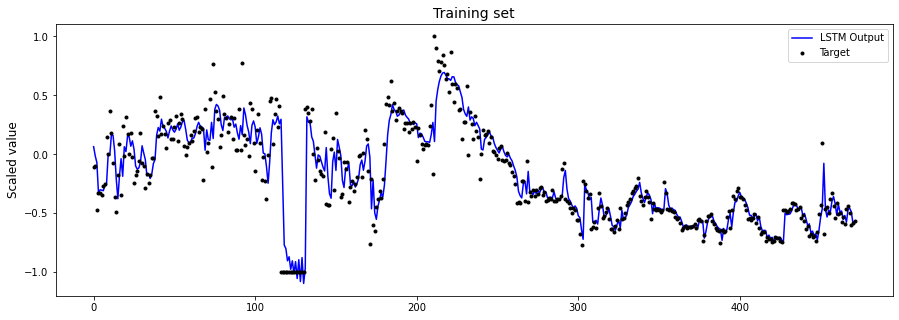

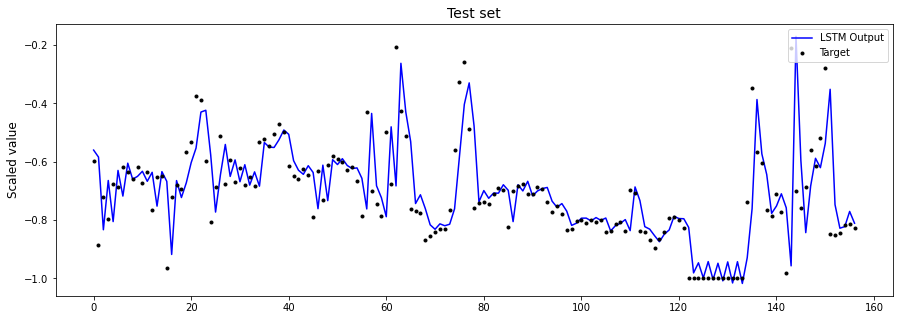

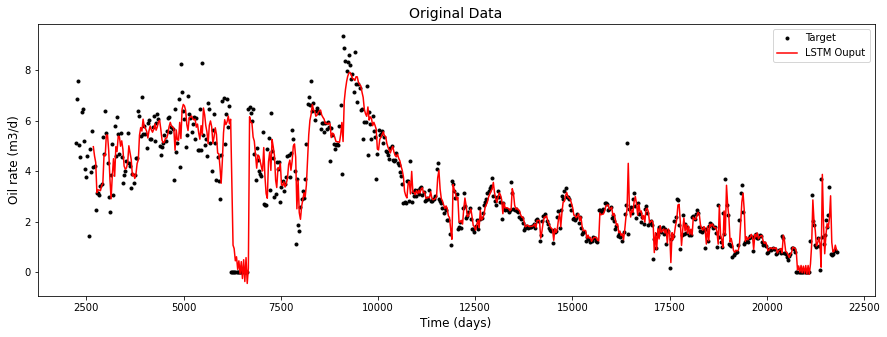

Test set MSE:  0.020374179137686556


In [7]:

seq_len=15

#Define the structure
model = Sequential(name="LSTM-Model") # Model
model.add(Input(shape=(seq_len,1), name='Input Layer')) # Input Layer
model.add(LSTM(units=300, activation='tanh', name='LSTM')) # Hidden Recurrent Layer
model.add(Dense(units=1, activation='linear', name='Output-Layer'))  # Output Layer

#Prepare Data
X,Y,X_test,Y_test,X_raw,Y_raw,Scaler1=PrepareData('Declination3.csv',seq_len,0.25)

#Compile the model
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['MeanSquaredError'])

#Train the RNN
model.fit(X, Y, batch_size=1, epochs=20)

#Predictions
# Predict the result on training data
y_train = model.predict(X)
# Predict the result on test data
y_test = model.predict(X_test)

#Plot the training set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_train, 'b', label='LSTM Output')
plt.plot(Y, '.k', label='Target')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Training set", fontsize=14)
plt.legend(loc='upper right') 
plt.show()

#Plot the test set using the scaled values
plt.figure(figsize=(15, 5)) 
plt.plot(y_test, 'b', label='LSTM Output')
plt.plot(Y_test, '.k', label='Target')
plt.ylabel('Scaled value', fontsize=12)
plt.title("Test set", fontsize=14)
plt.legend(loc='upper right') 
plt.show()

#Apply an inverse scale to plot everything on its original form
Y_train_raw=Scaler1.inverse_transform(y_train.reshape(-1,1))
Y_test_raw=Scaler1.inverse_transform(y_test.reshape(-1,1))
Y_train_raw=Y_train_raw.reshape(-1)
Y_test_raw=Y_test_raw.reshape(-1)
Y_predicted_raw=np.concatenate((Y_train_raw,Y_test_raw))

#Plot of the original data 
plt.figure(figsize=(15, 5)) 
plt.plot(X_raw,Y_raw,'.k', label='Target')
plt.plot(X_raw[seq_len:],Y_predicted_raw,'r', label='LSTM Ouput')
plt.title("Original Data", fontsize=14)
plt.ylabel('Oil rate (m3/d)', fontsize=12)
plt.xlabel('Time (days)', fontsize=12)
plt.legend(loc='upper right')
plt.show()

print("Test set MSE: ", mean_squared_error(Y_test,y_test))



## Example 2. Using a LSTM network to build a word predictor

For this second example we will use the LSTM network we just built to implement a very simple word predictor. In reality, this implementation is very inefficient but it is a good exercise to understand more complex models. We will start by using the previous LSTM network model and then we will work on a different case using Keras' LSTM network model.

### Case 1. Word predictor for a short text using the simple LSTM network

The main idea of this example is to generate a model able to predict the next word after reading a few input words. For this purpose, the model is trained using a text that contains all the words and their order. One way of applying recurrent neural networks to Natural Language Processing (NLP) problems such as this one is to assign a different index or identifier to each word so that the network can learn which word comes next.

Let's say that part of your text says "*Mary had a little lamb*". If you write the first 4 words, you would like the model to predict that the fifth word will be *lamb*. One way of modeling this is assigning an index to each word. If we assign one number to each word then it would be as saying that for the sequence `[0,1,2,3]` comes `[4]` that represents the word *lamb*. This means that, in order to use our LSTM network model, first we need to prepare all the data.

1. Read the file
2. Remove punctuation
3. Convert to lower case and save into words
4. Create `word_to_index` and `index_to_words` dictionaries
5. Generate traning sets

The following functions deal with the data preparation for this case. We will read the file `WMGGW.txt` that contains the words for the song "While my Guitar Gently Weeps" by The Beatles.

In [3]:
#STEP 1. Read the file with all the words
file_path = "WMGGW.txt"
with open(file_path, "r") as file:
    text = file.read()
    
#STEP 2. Remove punctuation from the text
text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation)) 
    
#STEP 3. Convert text to lowercase and split into words
words = text_without_punctuation.lower().split()

#STEP 4. Create word-to-index and index-to-word mappings
index=0
index_to_word={} #This dictionary contains the indexes and the words
word_to_index={} #This dictionary contains the words and the indexes
for word in (words):
    if word not in word_to_index:
        word_to_index[word] = index
        index_to_word[index]=word
        index += 1
        
#STEP 5. Generate input/target pairs to train the network. (Here we are asuming that the maximum number of words we will
#                                                          use to predict the next word is 4)
max_sequence_length = 4
X_train = []
y_train = []
for i in range(len(words) - max_sequence_length):
    X_train.append([word_to_index[word] for word in words[i:i+max_sequence_length]])
    y_train.append(word_to_index[words[i+max_sequence_length]])
    


With this we now have:
- `words` which is list of all the words in the song
- `index_to_word` which is a dictionary that contains the indexes and their corresponding words
- `word_to_index` which is a dictionary that contains the words and their corresponding indexes
- `X_train` and `y_train` which are the input/target pairs to train the model.
- A `max_sequence_length` of 4 which means that we cannot give an input larger than 4 words (you can change this)

We now need to define a function to train the LSTM network. We could use the previous one but with a few modifications since this time we won't be using a training and testing set but only training. Note that the following `train2` function is the same as `train` but with a few lines commented out:

In [5]:
### TRAINING ###
# Function: train2. This function works with the NLP example
# Input: 
#       - X: numpy array with the input data
#       - Y: numpy array with the target data
#       - Parameters: dictionary with the parameters
#       - epochs: number of epochs
#       - learning_rate
#       - MSE: boolean that defines if the MSE is printed at each epoch
#       - verbose: boolean that defines if the loss is printed at each iteration

# Output:
#       - Parameters: dictionary with the modified parameters after the training
#       - test_loss: final number of the loss for the test dataset
#       - A: table with the epoch and the test loss
def train2(X,Y,Parameters,epochs=20,learning_rate=0.0001,MSE=True,verbose=False):
    A=np.zeros((epochs,2))
    for k in range(epochs):
        loss=calc_loss(X,Y,Parameters,seq_len)
        #test_loss=calc_loss(X_test,Y_test,Parameters,seq_len)
        #y_test=prediction(X_test,Parameters,seq_len)
        #MSE_test=mean_squared_error(Y_test,y_test)
        
        if verbose==True:
            print(f'Epoch: {k+1}, Loss: {loss}')
        
        #Training
        for i in range(Y.shape[0]):
            
            xi,yi=X[i],Y[i]
            #Forward Propagation
            A2,cache=forwardprop(xi,Parameters)
            #Backward Propagation
            grads=backprop(xi,yi,A2,Parameters,cache)
            #Update Parameters
            
            Parameters["Whf"] += learning_rate*grads["d_Whf"][:,0]
            Parameters["bxf"] += learning_rate*grads["d_bxf"][:,0]
            Parameters["Wxf"] += learning_rate*grads["d_Wxf"][:,0]
            Parameters["Wh2"] += learning_rate*grads["d_Wh2"][:,0]
            Parameters["bx2"] += learning_rate*grads["d_bx2"][:,0]
            Parameters["Wx2"] += learning_rate*grads["d_Wx2"][:,0]
            Parameters["Wh3"] += learning_rate*grads["d_Wh3"][:,0]
            Parameters["bx3"] += learning_rate*grads["d_bx3"][:,0]
            Parameters["Wx3"] += learning_rate*grads["d_Wx3"][:,0]
            Parameters["Who"] += learning_rate*grads["d_Who"][:,0]
            Parameters["bxo"] += learning_rate*grads["d_bxo"][:,0]
            Parameters["Wxo"] += learning_rate*grads["d_Wxo"][:,0]
            
            Parameters["ht1"] += learning_rate*grads["d_ht1"][:,0]
            Parameters["Ct1"] += learning_rate*grads["d_Ct1"][:,0]
        A[k,0]=k
        A[k,1]=loss
        
        if k>1 and A[k,1]>A[k-1,1]:
            print("Validation loss increased")
            break
        
    loss=calc_loss(X,Y,Parameters,seq_len)
    #test_loss=calc_loss(X_test,Y_test,Parameters,seq_len)
    
    if MSE==True:
        print(f'The training loss is: {loss}')
    
    y_train=prediction(X,Parameters,seq_len)
    #y_test=prediction(X_test,Parameters,seq_len)
    MSE_train=mean_squared_error(Y,y_train)
    #MSE_test=mean_squared_error(Y_test,y_test)
    if MSE==True:
        print(f'The training MSE is: {MSE_train}' )
    
    
    return Parameters, loss, A, grads

Let's train the the model now. Remember that before passing the inputs we need to scale them from -1 to 1. The steps we will follow are:
1. Scale the inputs
2. Initialize the parameters
3. Train the model

In [8]:
# Define the maximum number of words each input sequence can have
seq_len=max_sequence_length

# Convert X_train and y_train to numpy arrays
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

# Flatten the arrays
X_train_flattened = X_train_array.flatten()
y_train_flattened = y_train_array.flatten()

# Initialize MinMaxScaler and fit it to the data
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train_flattened.reshape(-1, 1))  # Fit to flattened X_train array
scaler.fit(y_train_flattened.reshape(-1, 1))  # Fit to flattened y_train array

# Transform X_train and y_train using the fitted scaler
X_train_scaled = scaler.transform(X_train_flattened.reshape(-1, 1)).reshape(X_train_array.shape)
y_train_scaled = scaler.transform(y_train_flattened.reshape(-1, 1)).reshape(y_train_array.shape)

#Initialize parameters
Parameters=Get_Params(123)

#Train the model
New_Param,loss,A, grads=train2(X_train_scaled,y_train_scaled,Parameters,epochs=500,learning_rate=0.007,MSE=True,verbose=False)
print("End of training process")


Validation loss increased
The training loss is: [[14.69733401]]
The training MSE is: 0.229645843974573
End of training process


Now that the model is trained we can give it a group of words (fewer or the same number as than `max_sequence_length`) and the model will return its prediction. The following code:
1. Takes a group of words and generates sequence of indexes
1. Pads the sequence with zeros if it has fewer words than the maximum sequence length
1. Transforms this sequence into an array and scale it
1. Use the scaled array to predict the new value using the `forwardprop` function and the trained parameters (`New_Param`)
1. Apply the inverse scaling to the result and round it up to the nearest integer
1. Use the `index_to_word` dictionary to convert the index into a word


In [11]:
#Write the input group of words:
seed_text="my guitar gently"

#Sequence of indexes:
indexes_sequence = [word_to_index[word] for word in seed_text.lower().split()]

#Pad the sequence with zeros:
padded_sequence = np.pad(indexes_sequence, (max_sequence_length - len(indexes_sequence), 0), 'constant')

#Convert the padded sequence into an array and scale it
padded_sequence_array=np.array(padded_sequence)
X = scaler.transform(padded_sequence.flatten().reshape(-1, 1)).reshape(padded_sequence_array.shape)

#Predict the new value
predicted_index,cache = forwardprop(X,New_Param)

#Inverse scale the result and round it up to the nearest integer
predicted_index = scaler.inverse_transform(predicted_index[:,-1].reshape(1, -1))
predicted_index = int(np.round(predicted_index))

#Convert the index into a word
predicted_word = index_to_word[predicted_index]

print("The next word is: ", predicted_word)



The next word is:  weeps


### Case 2. Word predictor for a longer text using Keras LSTM network

Let's move on to a bigger and more realistic project. Let's say we now have all the words for all The Beatles song and we want to train an LSTM network to predict the next word. A better way of tackling this problem is to use more units for the LSTM layer as well as using a final dense layer with a [softmax](https://keras.io/api/layers/activations/#softmax-function) activation function. 

The model that we will use now looks like the following picture. Note how the input corresponds to a sequence of indexes like we had previously. However, this time before going into the LSTM layer, the input is connected to an embedding layer. This layer is used to convert integer-encoded representations of words (indexes) into dense vectors of fixed sizes. This means that this time each word will not be represented only by an index but by a higher-dimensional vector. Each value of the vector is a parameter that is learned during the training process. This is a common methodology in NLP tasks because it allows the model to better capture the relationships between words.  

<img src=inc\Embedding.png width=800/>

If you want more information about embedding layers, [this link](https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work) contains a very good explanation of it.

The other important thing to notice here is that we are using a **sparse categorical cross entropy** loss function. This means that the loss function will compare a vector that contains a probability distribution of each word (remember that the softmax activation function outputs a vector of probability distributions) with a one-hot encoded vector of the true value. 

Example: let's say that we have only three possible words (`[guitar, walrus, submarine]`) and the softmax output is `[0.1, 0.2, 0.8]` whereas the true value is `[walrus]` which means `[1]`. The sparse categorical cross entropy loss will convert `[1]` into a one-hot encoded vector `[0, 1, 0]` and then calculate:

$$Loss=-\sum_{i} y_{true,i} \times log(y_{pred,i})$$

In this case:
$$Loss=-(0 \times log(0.1)+1 \times log(0.2)+0 \times log(0.8))=0.69897$$

This loss value is calculated for each input/target pair of data accross all sequences and then it is backpropagated to calculate the new parameters.

Let's now read the file `TheBeatlesFull2.txt` that contains all the words for The Beatles songs. As we did previously, we start by removing the punctuation and converting the text to lowercase. After this we create the index to word and word to index dictionaries and generate the `X_train` and `y_train` sets. For this example we are going to use a maximum input length of 3 words.

In [22]:
# Read the text file
file_path = "TheBeatlesFull2.txt"
with open(file_path, "r", encoding='utf-8') as file:
    text = file.read()

# Remove punctuation
text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation)) 
    
# Convert text to lowercase and split into words
words = text_without_punctuation.lower().split()

# Create word-to-index and index-to-word mappings
index=0
index_to_word={}
word_to_index={}
for word in words:
    if word not in word_to_index:
        word_to_index[word] = index
        index_to_word[index]=word
        index += 1

# Generate input-output pairs for training the LSTM
max_sequence_length = 3
X_train = []
y_train = []
for i in range(len(words) - max_sequence_length):
    X_train.append([word_to_index[word] for word in words[i:i+max_sequence_length]])
    y_train.append(word_to_index[words[i+max_sequence_length]])
    
# Convert input sequences to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)


Now that we have the input data, let's build the LSTM network using Keras. You will notice that the `fit` instruction in the following code is commented out. The reason for this is that running a model like this takes some time (in a personal laptop). You can run the model or you can load a trained model with the same parameters. To do this use the `load` function. Note that if you choose to load the model, its performance will be worse than the proposed model since it had to weight less than 25 MB to save it in GitHub. 

In [23]:
# Build LSTM model
model = Sequential(name="LSTM-Model-Beatles")
model.add(Embedding(input_dim=len(words), output_dim=50, input_length=max_sequence_length, name="Embedding-Layer"))
model.add(LSTM(units=100,name="LSTM-Layer"))
model.add(Dense(len(words), activation='softmax', name="Softmax-layer"))

# Compile model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
#model.fit(X_train, y_train, epochs=100, verbose=2)
#      or
# Load model
model = load_model('inc/beatles_emb15_ep_75_max_3words_units40.2024.04.23.h5')


With this model we can predict the next word using a maximum input of 3 words. To do that, we follow a similar process to the one explained for the previous case.

In [24]:
# Define the input text
input_text="long and winding"

# Convert the text into a sequence of indexes
input_sequence = [word_to_index[word] for word in input_text.lower().split()]

# Pad the sequence in case is shorter than the max_sequence_length
padded_sequence = np.pad(input_sequence, (max_sequence_length - len(input_sequence), 0), 'constant')

# Use the model to predict the next index
predicted_index = np.argmax(model.predict(np.array([padded_sequence])))

# Convert the predicted index into a word
predicted_word = index_to_word[predicted_index]

print("Input text and its prediction: ")
print(input_text, " --> ", predicted_word)


1/1 [==============================] - 0s 294ms/step
Input text and its prediction: 
long and winding  -->  road


We can go one step further and try to predict a group of words:

In [26]:

input_text="nowhere man"
num_words=100

generated_text = input_text.lower()

for _ in range(num_words):
    # Convert seed text to indices
    input_sequence = [word_to_index.get(word, 0) for word in generated_text.split()]
    input_sequence = np.array(input_sequence)[np.newaxis, :]
    # Predict the next word
    predicted_index = np.argmax(model.predict(input_sequence))
    predicted_word = index_to_word.get(predicted_index)
    # Add the new word to the text
    generated_text += ' ' + predicted_word

print("The generated text is: ", generated_text)
    


1/1 [==============================] - 0s 17ms/step
The generated text is:  nowhere man me you silly silly baby sunshine baby sunshine baby sunshine baby sunshine baby sunshine baby long to change with to love but i can work it dig it dig it dig it dig it dig it dig a chains to jonah once tasting back in hand home in their water coconut home in in our home home oh we’re on in our home home oh we’re on home home oh we’re on in my knee hole an very honey good way making in all my heart and a very sunshine sunshine sunshine good good so happy happy happy happy happy


## Conclusion

This Jupyter Notebook contains some examples about the application of LSTM networks and how they work. If you want more information about this, there are many resources online that you can check. Don't forget to read the article [To Know Is Also to Remember](https://medium.com/towards-data-science/to-know-is-also-to-remember-e786cc6242ae) that goes with this notebook!